In [1]:
import os
import numpy

#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import time
import gzip

from IPython.display import clear_output

# K-means

In [2]:
def my_distance_matrix(x, y):
    x = x.astype(numpy.float64)
    y = y.astype(numpy.float64)
    assert len(x.shape) == len(y.shape) == 2
    assert x.shape[1] == y.shape[1]
    
    # (a - b) ** 2 = (a, a) - 2 (a, b) + (b, b)
    distances = (x @ (-2 * y.T))
    distances += numpy.linalg.norm(x, axis=-1)[:, None] ** 2
    distances += numpy.linalg.norm(y, axis=-1)[None, :] ** 2
    distances[distances < 0] = 0
    distances = numpy.sqrt(distances, out=distances)
    return distances

class k_means:
    def __init__(self, k, init=None):
        if init is None:
            init = self._random_choice
        self.init = init
        self.nclusters = k
        self.centers = None
        self.debug = False

    @staticmethod
    def _random_choice(n, x):
        return (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
                .choice(x, size=n, replace=False))

    def train(self, x, debug=False):
        self.centers = self.init(self.nclusters, x)
        prev = None
        while (prev != self.centers).all():
            cl = self.clusters(x)
            # new centers are means of each group
            new = numpy.array([
                    x.mean(axis=0) if len(x) else self.centers[i]
                    for i, x in enumerate(cl)])
            self.centers, prev = new, self.centers
        return self

    def __call__(self, x):
        assert self.centers is not None
        return my_distance_matrix(x, self.centers).argmin(axis=1)
    
    def clusters(self, x):
        assert len(x.shape) == 2
        cl = self(x)
        return [x[cl == i] for i in range(self.centers.shape[0])]

In [3]:
from scipy.spatial import distance_matrix
gg, hh = numpy.random.randn(100, 100), numpy.random.randn(200, 100)
print(abs(distance_matrix(gg, hh) - my_distance_matrix(gg, hh)).max())

5.329070518200751e-15


### classifier

In [4]:
def init_farthest(n, x):
    y = (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
            .choice(x, size=1))
    for i in range(n-1):
        y = numpy.concatenate([
                (x[my_distance_matrix(x, y, ).min(axis=1).argmax()]
                        .reshape(1, -1)),
                y])
    return y

def init_plusplus(n, x):
    y = (numpy.random.default_rng(seed=numpy.random.randint(0, 2**32))
            .choice(x, size=1))
    for i in range(n-1):
        probs = my_distance_matrix(x, y).min(axis=1) ** 2
        probs /= probs.sum()
        cs = numpy.cumsum(probs)
        r = numpy.random.rand()
        y = numpy.concatenate([
            x[(cs < r) & (probs != 0)][0:1],
            y])
    return y

In [5]:
def strange_clustering_loss(clusters):
    avg = 0
    for c in clusters:
        n = len(c)
        avg += my_distance_matrix(c, c).mean() / n
    cc = numpy.concatenate(clusters)
    n = len(cc)
    return avg

In [6]:
def flatten(x):
    return x.reshape(x.shape[0], -1)

In [7]:
def train_classifier(x_train, y_train, nclusters, nclasses):
    model = k_means(nclusters)
    model.train(x_train)
    y = model(x_train)
    class_p = []
    for i in range(nclusters):
        y_i = y_train[y == i]
        class_p.append(numpy.array([(y_i == j).mean() for j in range(nclasses)]))
    class_p = numpy.array(class_p)
    class_argmax = class_p.argmax(axis=1)

    return model, lambda x: class_argmax[model(x)]

# Loading data

In [8]:
!kaggle competitions download -c iml2020-bank
!unzip iml2020-bank.zip

iml2020-bank.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  iml2020-bank.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
import pandas as pd

In [384]:
data = pd.read_csv('train.csv')

### train test split

In [385]:
train = data.copy()
train.fillna(-11, inplace=True)

test = pd.read_csv('test.csv')
test.fillna(-11, inplace=True)

y_cols, x_cols = map(list, (train.columns[:1], train.columns[1:]))
print(y_cols, x_cols)

['плохой_клиент'] ['линии', 'возраст', 'поведение_30-59_дней', 'Debt_Ratio', 'доход', 'число_кредитов', 'поведение_90_дней', 'недвижимость', 'поведение_60-89_дней', 'семья']


In [386]:
def train_test_split(x, y, ntest):
    ind = numpy.arange(y.shape[0])
    numpy.random.shuffle(ind)
    return x[ind[ntest :]], y[ind[ntest :]], x[ind[: ntest]], y[ind[: ntest]]

In [387]:
x_tr = train[x_cols].to_numpy()
y_tr = (train[y_cols].to_numpy().flatten() > 0.5) * 1

In [388]:
x_train, y_train, x_test, y_test = train_test_split(x_tr, y_tr, int(y_tr.shape[0] * 0.1))

# not random forest classisfier

In [389]:
import sklearn
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.naive_bayes
import sklearn.neighbors

In [428]:
model = sklearn.ensemble.VotingRegressor(estimators=[
        ('RF1', sklearn.ensemble.RandomForestRegressor(max_depth=11)),
        ('RF2', sklearn.ensemble.RandomForestRegressor(max_depth=15)),
        ('GB1', sklearn.ensemble.GradientBoostingRegressor(max_depth=3)),
        ('GB2', sklearn.ensemble.GradientBoostingRegressor(n_estimators=500, max_depth=1)),
        ('GB3', sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=10)),
        ('AB', sklearn.ensemble.AdaBoostRegressor())
        ], n_jobs=8)

In [429]:
try:
    model.fit(x_train, y_train)
except:
    !notify-send jupyter error --urgency=critical

In [430]:
loss(y_train, (model.predict(x_train) > 0.06)*1)

0.8267125995773688

In [431]:
mavg = 0
loss = lambda y_test, y_pred: 0.5 * sum([(y_pred[y_test == i] == y_test[y_test == i]).mean() for i in range(2)])
for th in numpy.linspace(0.04, 0.1, 21):
    y_pred = (model.predict(x_test) > th)*1

    q1 = (y_pred[y_test == 1] == y_test[y_test == 1]).mean()
    q2 = (y_pred[y_test == 0] == y_test[y_test == 0]).mean()
    print(round(th, 6), q1, q2, 'avg =', (q1+q2)/2, sep='\t')
    mavg = max(mavg, (q1+q2)/2)
print('\nmax avg =', mavg)

0.04	0.8691709844559585	0.6597633136094675	avg =	0.7644671490327131
0.043	0.8588082901554405	0.6714067570146974	avg =	0.765107523585069
0.046	0.8510362694300518	0.6842908952090093	avg =	0.7676635823195306
0.049	0.8458549222797928	0.6972704714640199	avg =	0.7715626968719063
0.052	0.8419689119170984	0.7121588089330024	avg =	0.7770638604250504
0.055	0.8354922279792746	0.7267608322198893	avg =	0.781126530099582
0.058	0.8173575129533679	0.7393586562321054	avg =	0.7783580845927367
0.061	0.805699481865285	0.7502385951517465	avg =	0.7779690385085157
0.064	0.7979274611398963	0.7610230960106891	avg =	0.7794752785752928
0.067	0.788860103626943	0.7719030349303302	avg =	0.7803815692786367
0.07	0.7707253886010362	0.7824966596678755	avg =	0.7766110241344559
0.073	0.7603626943005182	0.7928994082840237	avg =	0.776631051292271
0.076	0.7461139896373057	0.8031112807787746	avg =	0.7746126352080401
0.079	0.7370466321243523	0.8120824584844436	avg =	0.7745645453043979
0.082	0.7318652849740933	0.82172170261500

In [432]:
!notify-send jupyter computed --urgency=critical

### saving solution

In [435]:
f = lambda th: lambda x: x/th/2 * (x<=th) + ((x-th)/(1-th)+1)/2 * (x>th)
y_test_predict = f(0.055)(numpy.clip(model.predict(test.to_numpy()), 0, 1))
pd.DataFrame({'id': numpy.arange(len(y_test_predict)), 'a': y_test_predict}).to_csv('solution.csv', index=False)

In [441]:
((y_train - f(0.055)(numpy.clip(model.predict(x_train), 0, 1)))**2).mean()**.5

0.3299507523305936

# k-means testing

In [10]:
train = data.copy()
pseudo_inf = 1000 * train.max().max()
train.fillna(pseudo_inf, inplace=True)

In [48]:
bad = train.loc[(train[y_cols[0]] == 1).to_numpy()].to_numpy()
badn = numpy.concatenate([bad for i in range(len(train) // len(bad) - 1)])
train = train.append(pd.DataFrame(data=badn, columns=y_cols+x_cols, index=numpy.arange(len(badn))+len(train)))

In [49]:
len(train)

210572

In [51]:
x_tr = train[x_cols].to_numpy()
y_tr = (train[y_cols].to_numpy().flatten() > 0.5) * 1

In [52]:
x_train, y_train, x_test, y_test = train_test_split(x_tr, y_tr, int(y_tr.shape[0] * 0.1))

In [61]:
model, classifier = train_classifier(x_train, y_train, 100, 2)

/home/abrikos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


In [62]:
(classifier(x_test) == 0).mean()  # stupid k-means

0.5265232464263665

In [63]:
(classifier(x_test) == y_test).mean()

0.5733485301799877

In [57]:
del model, classifier

# sth other

In [65]:
data

,плохой_клиент,линии,возраст,поведение_30-59_дней,Debt_Ratio,доход,число_кредитов,поведение_90_дней,недвижимость,поведение_60-89_дней,семья
0,0,0.031258,57,0,0.397520,5000.0,15,0,2,0,0.0
1,0,0.052332,64,0,57.000000,NaN,2,0,0,0,NaN
2,0,1.051793,40,1,444.000000,NaN,2,1,0,0,0.0
3,0,0.981993,40,1,0.780109,6625.0,8,0,1,0,4.0
4,0,0.163684,67,0,0.317596,4574.0,5,0,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
112495,0,0.017400,90,0,30.000000,NaN,10,0,0,0,NaN
112496,0,0.009396,55,0,0.230803,4583.0,18,0,1,0,0.0
112497,1,0.991441,44,2,0.482681,3550.0,7,0,1,1,2.0
112498,0,0.170114,39,1,0.158226,4600.0,16,0,0,0,2.0


In [103]:
data['плохой_клиент'].to_numpy().sum()

7544

In [197]:
datax, datay = data[x_cols].to_numpy(), data[y_cols].to_numpy().reshape(-1)
datax.shape, datay.shape

((112500, 10), (112500,))

In [198]:
badi = (datay == 1)

In [199]:
datax_mean = data.mean(axis=0)[x_cols].to_numpy()
datax_std = data.std(axis=0)[x_cols].to_numpy()

In [200]:
datax = (datax - datax_mean) / datax_std

In [201]:
datax[datax != datax] = -100

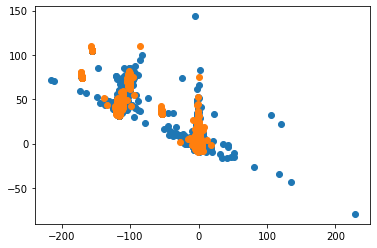

In [245]:
%matplotlib inline
wx = numpy.random.randn(len(x_cols))
wy = numpy.random.randn(len(x_cols))
x, y = datax @ wx, datax @ wy
plt.scatter(x[~badi], y[~badi])
plt.scatter(x[badi], y[badi])

In [320]:
def corr(x, y):
    return ((x - x.mean()) * (y - y.mean())).mean() / x.std() / y.std()

def m(x, y):
    x, y = map(lambda x: x.to_numpy(), (x, y))
    print('&', 'x', '!x', sep='\t')
    print('y', (x&y).sum(), (y&~x).sum(), sep='\t')
    print('!y', (x&~y).sum(), ((~x)&~y).sum(), sep='\t')

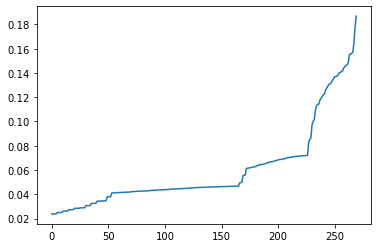

4117233 6140.505029678345


/home/abrikos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [344]:
i = [-2 for i in range(len(x_cols))]
cormax = [(None, -2)]
y = (data['плохой_клиент']==1).to_numpy()
t = time.time()
k = 1
while sum(i) != 2 * len(x_cols):
    x = (datax @ i)
    c = abs(corr(x, y))
    if c > cormax[-1][-1]:
        cormax.append((i, c))
        cc = [cc[-1] for cc in cormax]
        clear_output(True)
        plt.plot(cc[1:])
        plt.show()
        print(k, time.time() - t)
    k += 1
    j = 0
    i[j] += 1
    while i[j] > 2:
        i[j] = -2
        j += 1
        i[j] += 1

In [334]:
w = numpy.random.randint(-1, 2, size=len(x_cols))
print(w)
x, y = (datax @ w), (data['плохой_клиент']==1).to_numpy()
print('corr:', corr(x, y))

[ 0 -1  1  1  1 -1  1 -1  0  1]
corr: 0.028030959927498062


In [298]:
x, y = data['Debt_Ratio'] < 100000, data['плохой_клиент']==1
m(x, y)
print('corr:', corr(x, y))

&	x	!x
y	7544	0
!y	104951	5
corr: 0.0017873746601126338


In [252]:
for i in range(100):
    i = numpy.random.randint(len(data))
    print(data[x_cols].loc[i])
    l = int(input())
    print(data[y_cols].loc[i])
    print()

линии                      0.649591
возраст                   37.000000
поведение_30-59_дней       1.000000
Debt_Ratio                 0.218188
доход                   9500.000000
число_кредитов             7.000000
поведение_90_дней          0.000000
недвижимость               1.000000
поведение_60-89_дней       0.000000
семья                      2.000000
Name: 30760, dtype: float64


 0


плохой_клиент    1
Name: 30760, dtype: int64

линии                     0.988301
возраст                  26.000000
поведение_30-59_дней      0.000000
Debt_Ratio              625.000000
доход                          NaN
число_кредитов            6.000000
поведение_90_дней         0.000000
недвижимость              0.000000
поведение_60-89_дней      0.000000
семья                     0.000000
Name: 68516, dtype: float64


 0


плохой_клиент    0
Name: 68516, dtype: int64

линии                    0.416717
возраст                 85.000000
поведение_30-59_дней     0.000000
Debt_Ratio              62.000000
доход                         NaN
число_кредитов           1.000000
поведение_90_дней        0.000000
недвижимость             0.000000
поведение_60-89_дней     0.000000
семья                         NaN
Name: 36075, dtype: float64


 0


плохой_клиент    0
Name: 36075, dtype: int64

линии                      0.025936
возраст                   44.000000
поведение_30-59_дней       0.000000
Debt_Ratio                 0.201107
доход                   5961.000000
число_кредитов             6.000000
поведение_90_дней          0.000000
недвижимость               1.000000
поведение_60-89_дней       0.000000
семья                      0.000000
Name: 53225, dtype: float64


 0


плохой_клиент    0
Name: 53225, dtype: int64

линии                      0.464533
возраст                   69.000000
поведение_30-59_дней       0.000000
Debt_Ratio                 0.499639
доход                   2769.000000
число_кредитов            12.000000
поведение_90_дней          0.000000
недвижимость               1.000000
поведение_60-89_дней       0.000000
семья                      0.000000
Name: 93857, dtype: float64


KeyboardInterrupt: Interrupted by user